# Drought Network - Refinement

a. stein

8.4.2022

This picks up where `explore/drought_event_network.ipynb` left off, presenting a cleaner demonstration of the test case and cleaning up plotting functionality.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
import geopandas as gpd

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.drought_network as dnet


import networkx as nx

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_1850318/3732581631.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Test Cases - Cellular Automata

In [2]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

### 3x3 bounded grid (hard-coded)

In [3]:
ca_matrix_3x3 = np.array([
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
])
ca_matrix_3x3

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

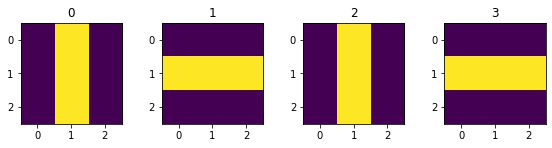

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(8,2))

ca_series_3x3 = []
plot_matrix = ca_matrix_3x3

for i, ax in enumerate(axs.ravel()):
    ca_series_3x3.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

ca_series_3x3 = np.array(ca_series_3x3)

plt.tight_layout()

In [5]:
ca_net_3x3 = dnet.DroughtNetwork(ca_series_3x3, name="3x3 Cellular Automata")

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
print(ca_net_3x3)

3x3 Cellular Automata: DroughtNetwork with D1 threshold, spawned 11-08-2022 15:16:25


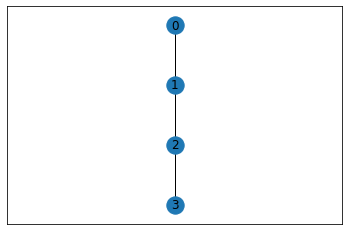

In [7]:
topog, pos = ca_net_3x3.get_nx_network()
nx.draw_networkx(topog, pos)

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

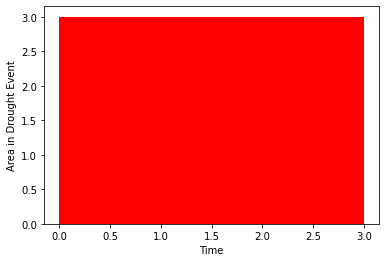

In [8]:
ca_net_3x3.stacked_events_plot()

### 5x5 bounded grid (hard-coded)

In [9]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
ca_matrix_5x5 = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

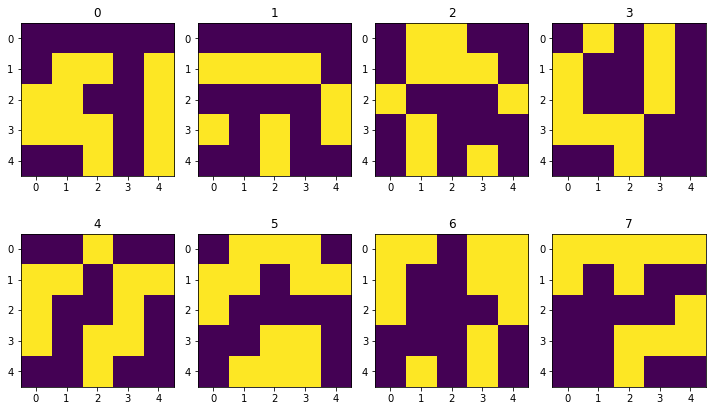

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

ca_series_5x5 = []
plot_matrix = ca_matrix_5x5

for i, ax in enumerate(axs.ravel()):
    ca_series_5x5.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

ca_series_5x5 = np.array(ca_series_5x5)

plt.tight_layout()

In [11]:
ca_net_5x5 = dnet.DroughtNetwork(ca_series_5x5, name="5x5 Cellular Automata")

  0%|          | 0/8 [00:00<?, ?it/s]

In [12]:
print(ca_net_5x5)

5x5 Cellular Automata: DroughtNetwork with D1 threshold, spawned 11-08-2022 15:16:31


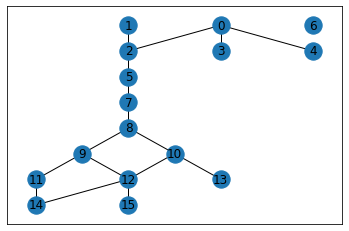

In [13]:
topog, pos = ca_net_5x5.get_nx_network()
nx.draw_networkx(topog, pos)

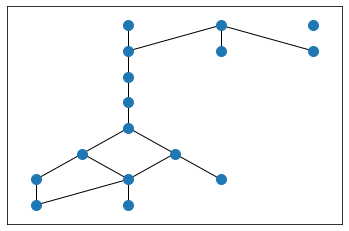

In [14]:
nx.draw_networkx(topog, pos, with_labels=False, node_size=100)

Let's look at a few different drawing options

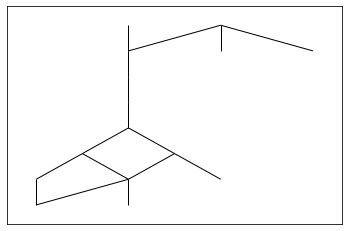

In [15]:
nx.draw_networkx_edges(topog, pos)

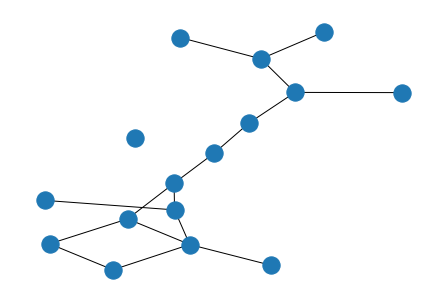

In [16]:
nx.draw_kamada_kawai(topog)

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

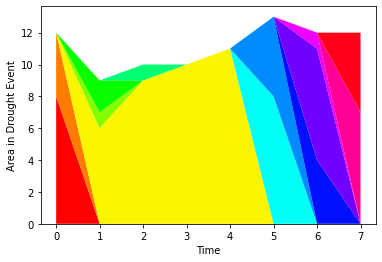

In [17]:
ca_net_5x5.stacked_events_plot()

### 15x15 bounded grid (random)

In [18]:
ca_matrix_15x15 = np.zeros((15,15))

for i in np.arange(ca_matrix_15x15.shape[0]):
    for j in np.arange(ca_matrix_15x15.shape[1]):
        ca_matrix_15x15[i][j] = np.random.randint(2)

ca_matrix_15x15

array([[1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.],
       [0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.],
       [1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.],
       [0., 0., 0., 1., 0., 0., 1.

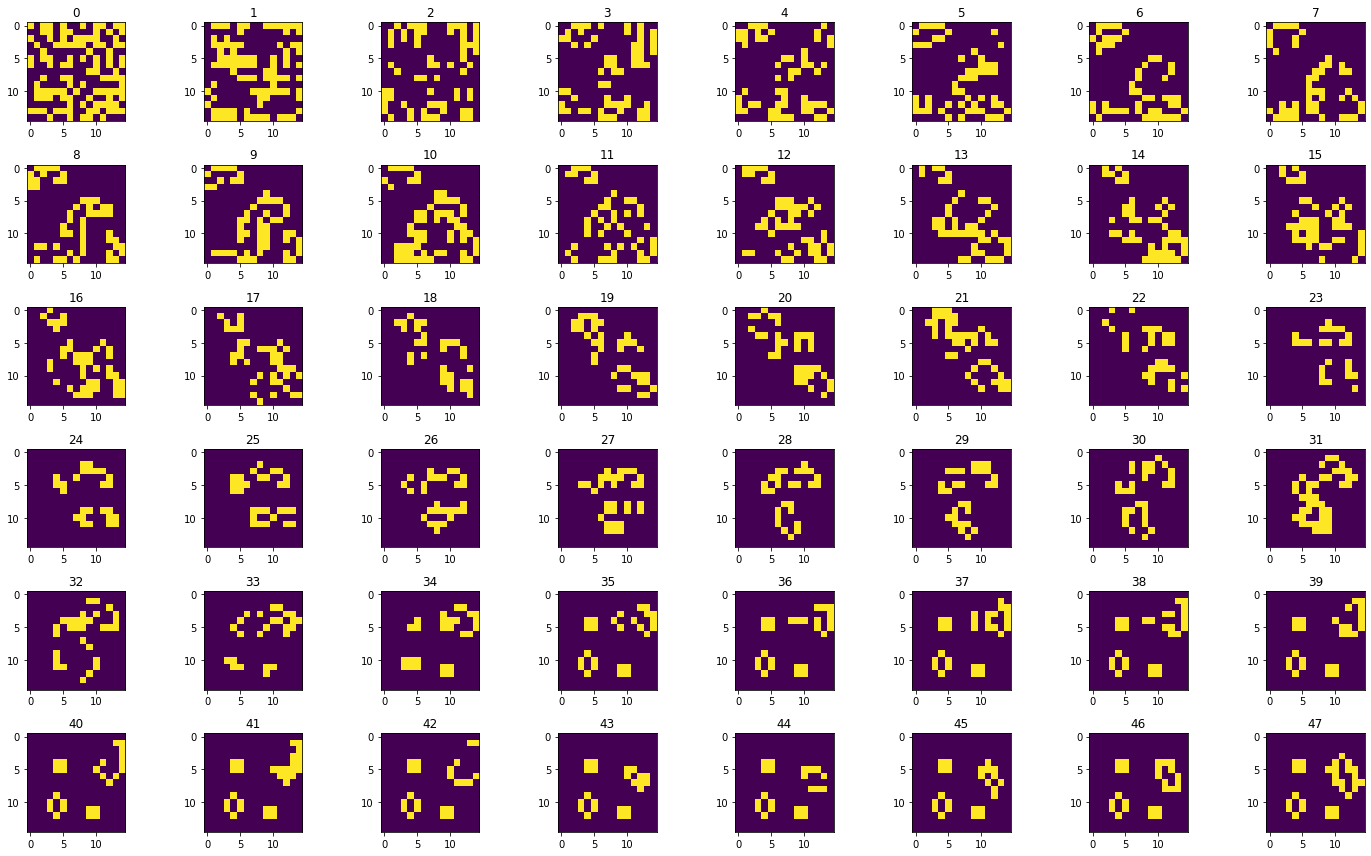

In [19]:
fig, axs = plt.subplots(6, 8, figsize=(20,12))

ca_series_15x15 = []
plot_matrix = ca_matrix_15x15

for i, ax in enumerate(axs.ravel()):
    ca_series_15x15.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

ca_series_15x15 = np.array(ca_series_15x15)

plt.tight_layout()

In [20]:
ca_net_15x15 = dnet.DroughtNetwork(ca_series_15x15, name="15x15 Cellular Automata")

  0%|          | 0/48 [00:00<?, ?it/s]

In [21]:
print(ca_net_15x15)

15x15 Cellular Automata: DroughtNetwork with D1 threshold, spawned 11-08-2022 15:16:40


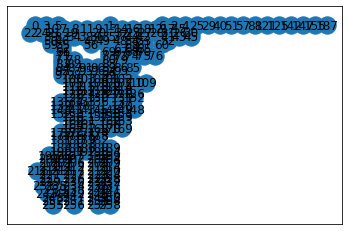

In [22]:
topog, pos = ca_net_15x15.get_nx_network()
nx.draw_networkx(topog, pos)

Can I make that easier to read?

In [23]:
color_map = []
cmap = plt.cm.get_cmap('hsv')
max_area = 15*15

for node in ca_net_15x15.nodes:
    area_percent = node.area/max_area
    color_map.append(cmap(area_percent)[:-1])

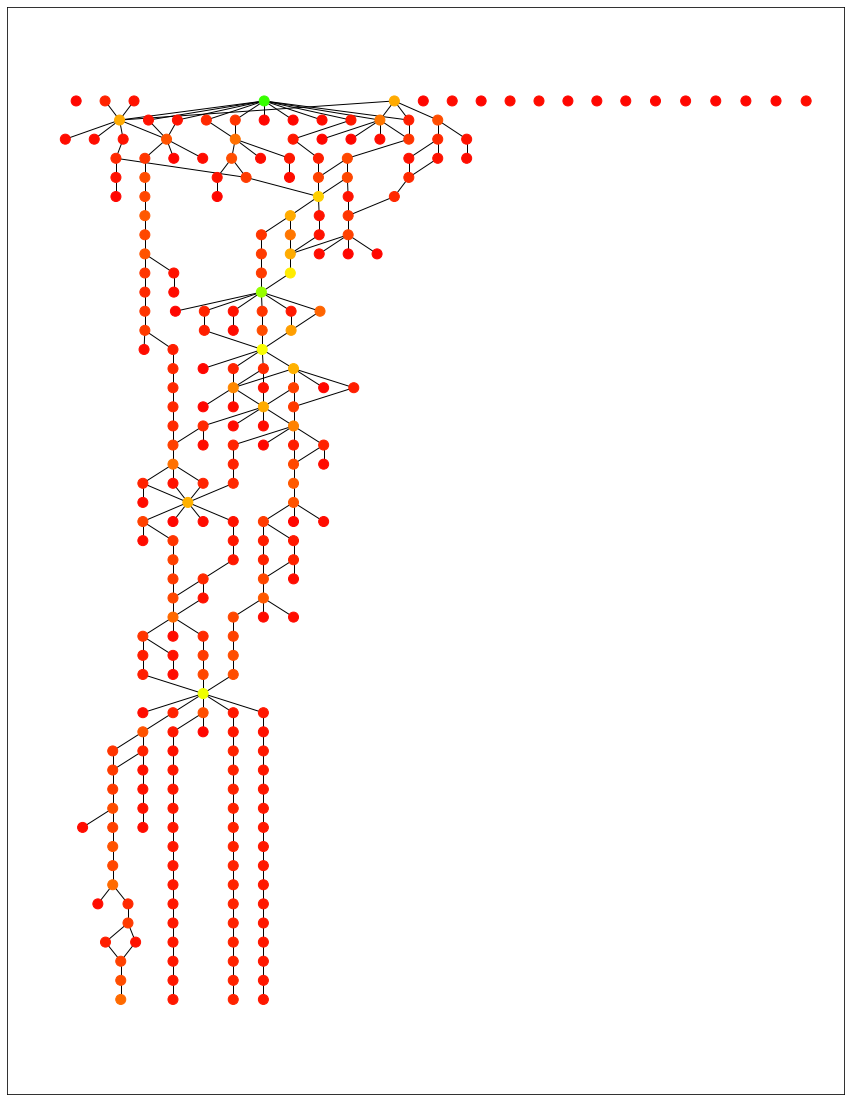

In [24]:
fig, ax = plt.subplots(figsize=(15,20))

nx.draw_networkx(topog, pos, ax=ax, node_size=100, with_labels=False, node_color=color_map)

Interesting. That definitely helps 

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

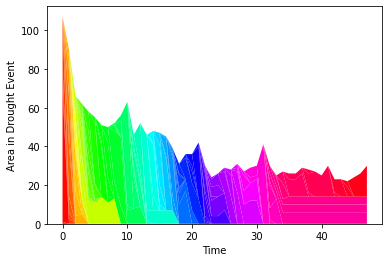

In [25]:
ca_net_15x15.stacked_events_plot()

## Application - USDM

In [26]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

In [27]:
usdm = xr.open_dataarray(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')
usdm

<xarray.DataArray 'USDM' (date: 1163, lat: 139, lon: 314)>
[50760298 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon      (lon) float64 -124.7 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -124.74590760646159 0.024999999999999963 0....

In [28]:
usdm_net = dnet.DroughtNetwork(usdm.values, name='USDM EPSG:4326')

  0%|          | 0/1163 [00:00<?, ?it/s]

In [29]:
print(usdm_net)

USDM EPSG:4326: DroughtNetwork with D1 threshold, spawned 11-08-2022 15:16:45


<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

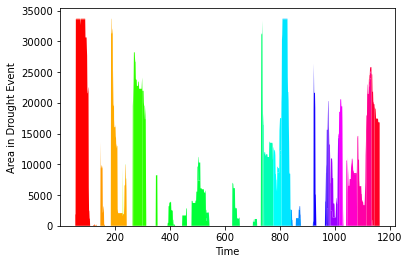

In [30]:
usdm_net.stacked_events_plot()

In [31]:
topog, pos = usdm_net.get_nx_network()

In [32]:
from datetime import datetime
datetime.now().strftime("%d-%m-%Y %H:%M:%S")

'11-08-2022 15:19:57'

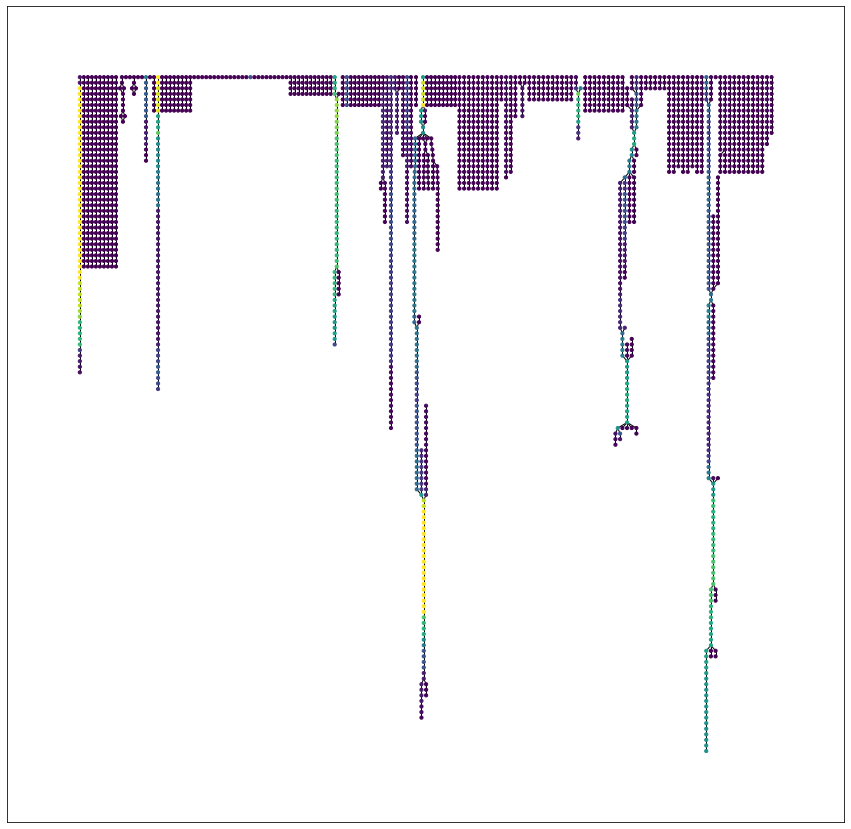

In [33]:
fig, ax = plt.subplots(figsize=(15,15))

nx.draw_networkx(topog, pos, ax=ax, with_labels=False, node_size=10, node_color=usdm_net.relative_area_color_map(cmap=plt.cm.get_cmap('viridis')))

Can see the cycles of droughts starting small and growing then fading ... wonder if a logarithmic scale might actually be helpful ...

Let's try pickling 

In [34]:
out_path = f'{dm_path}/usdm/usdm_WA_net.pickle'

try:
    os.remove(out_path)
except:
    pass

usdm_net.pickle(path=out_path)
test_pickle = dnet.DroughtNetwork.unpickle(path=out_path)

In [35]:
usdm_net.origins[0] == test_pickle.origins[0]

True

In [36]:
test_pickle == usdm_net

True

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

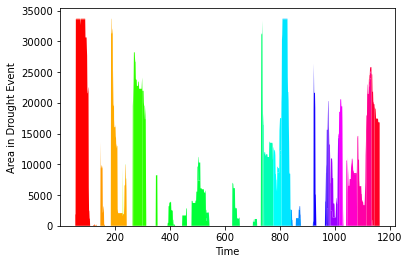

In [37]:
test_pickle.stacked_events_plot()

Wonderful!

## Application - SPI

In [38]:
spi_intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y']

From trying a while ago, processing these takes a while, so I'm going to first directly pickle them

In [39]:
for interval in tqdm(spi_intervals):
    path = f'{dm_path}/spi/WA/spi_{interval}_net.pickle'


    if not os.path.exists(path):

        data = xr.open_dataset(f'{dm_path}/spi/WA/spi_usdmcat_WA.nc')[f'spi_{interval}']
        net = dnet.DroughtNetwork(data.values, name=f'SPI {interval} EPSG:4326')
        
        try:
            os.remove(path)
        except:
            pass

        net.pickle(path)
        data = None

  0%|          | 0/8 [00:00<?, ?it/s]

Why ...

In [40]:
spi_5y = xr.open_dataset(f'{dm_path}/spi/WA/spi_usdmcat_WA.nc')[f'spi_5y']
spi_5y_net = dnet.DroughtNetwork(spi_5y.values, name=f'SPI 5y EPSG:4326')

  0%|          | 0/1148 [00:00<?, ?it/s]

In [43]:
sys.setrecursionlimit(int(1e4))

In [45]:
1e4

10000.0

In [44]:
path = f'{dm_path}/spi/WA/spi_5y_net.pickle'

try:
    os.remove(path)
except:
    pass

spi_5y_net.pickle(path)

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

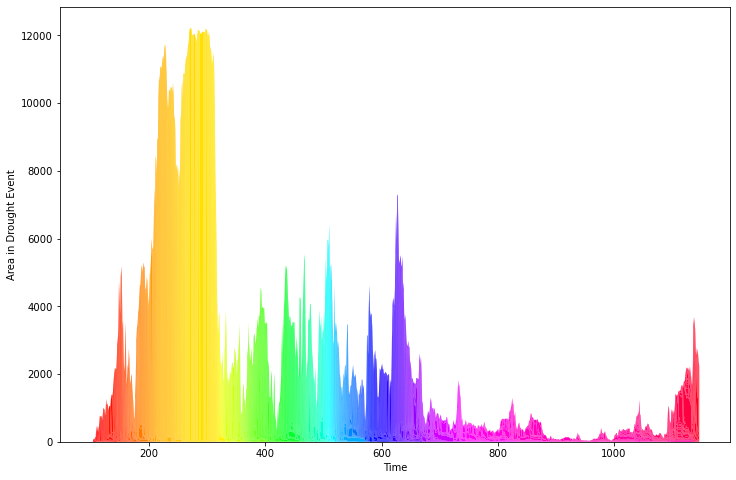

In [46]:
fig, ax = plt.subplots(figsize=(12,8))

spi_5y_net.stacked_events_plot(ax=ax)

In [47]:
topog, pos = spi_5y_net.get_nx_network()

In [48]:
len(spi_5y_net.nodes)

41479

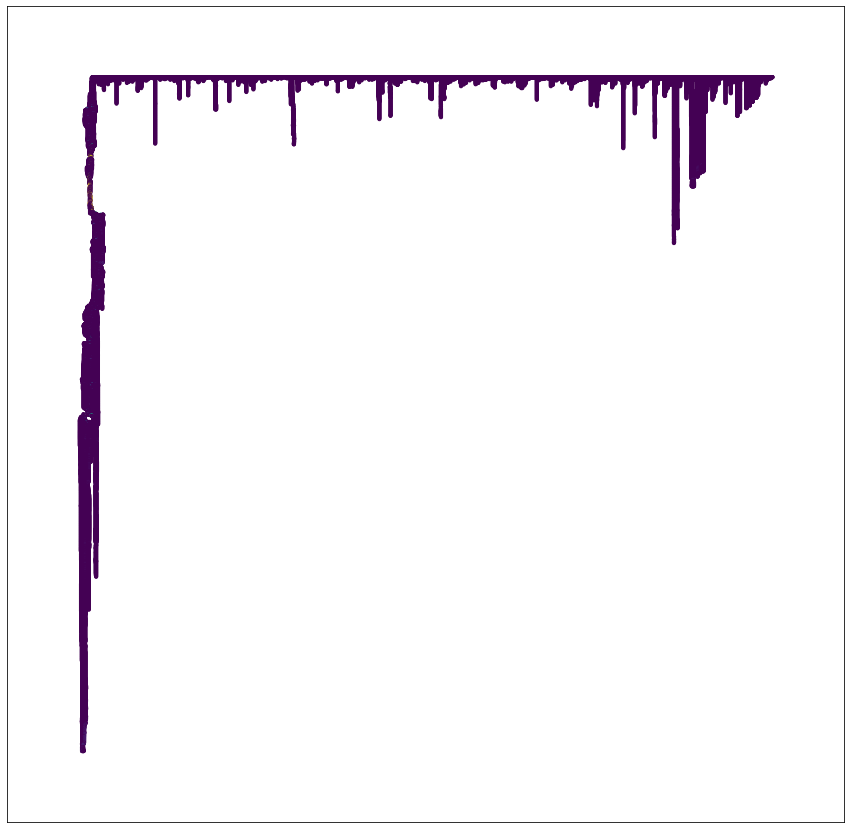

In [49]:
fig, ax = plt.subplots(figsize=(15,15))

nx.draw_networkx(topog, pos, ax=ax, with_labels=False, node_size=10, node_color=spi_5y_net.relative_area_color_map(cmap=plt.cm.get_cmap('viridis')))

Oh that's why ... we have one that just hangs on a really long time ...